In [2]:
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from correlated_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
    circuit_gate_times,
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from ppo import make_train_ppo
from helper_functions import load_from_yaml_file
from gymnasium.wrappers import RescaleAction, ClipAction


import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Operator
from qiskit.circuit.library import RXGate, SXGate, IGate, CRXGate, UGate, XGate
import qiskit_aer.noise as noise
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators.measures import average_gate_fidelity, state_fidelity
from qiskit.quantum_info.states import DensityMatrix, Statevector

from itertools import product
from scipy.linalg import expm

In [3]:
def get_ideal_circ(phi):
    ideal_circ = QuantumCircuit(2, name=f"custom_cx")
    # ideal_circ.h([0, 1])
    # x_gate = Operator(XGate())
    # rx_op = Operator(expm(-1j * phi * x_gate.data))
    # rx_op = Operator(RXGate(phi))
    # ideal_circ.unitary(rx_op, [0], label="rx(phi)")
    ideal_circ.rx(phi, 0)
    ideal_circ.cx(0, 1)
    return ideal_circ

In [4]:
def is_unitary(matrix):
    return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)

In [7]:
def build_noisy_circ(phi):
    custom_rx_gate_label = 'custom_kron(rx,ident)_gate'
    circuit = QuantumCircuit(2)
    # circuit.h([0, 1])
    # rx_op = Operator(RXGate(phi))
    # identity_op = Operator(IGate())
    # rx_op_2q = Operator(identity_op.tensor(rx_op))
    # circuit.unitary(rx_op_2q, [0, 1], label=custom_rx_gate_label)
    

    # x_gate = Operator(XGate())
    identity_op = Operator(IGate())
    rx_op = Operator(RXGate(phi))
    # rx_2q_gate = Operator(expm(-1j * phi * identity_op.tensor(x_gate)))
    rx_2q_gate = Operator(identity_op.tensor(rx_op))
    circuit.unitary(rx_2q_gate, [0, 1], label=custom_rx_gate_label)

    print('Decomposed 2-qubit RX(phi) gate:\n',circuit.decompose())

    
    # Model custom CX gate
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    circuit.u(
        optimal_params[0],
        optimal_params[1],
        optimal_params[2],
        0,
    )   
    circuit.u(
        optimal_params[3],
        optimal_params[4],
        optimal_params[5],
        1,
    )
    circuit.rzx(optimal_params[6], 0, 1)

    # circuit.save_superop()
    circuit.save_density_matrix()
    return circuit

Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
                        


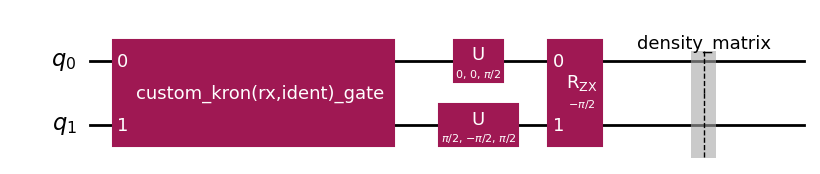

In [8]:
build_noisy_circ(np.pi/4).draw('mpl')

In [9]:
def bind_noise_get_backend(gamma, phi):

    # x_gate = Operator(XGate())
    identity_op = Operator(IGate())
    rx_op = Operator(RXGate(gamma*phi))
    # ident_rx_op = Operator(expm(-1j * (gamma*phi) * x_gate.tensor(identity_op)))
    ident_rx_op = Operator(rx_op.tensor(identity_op))

    custom_rx_gate_label = 'custom_kron(rx,ident)_gate'
    noise_model = noise.NoiseModel()
    # coherent_crx_noise = noise.coherent_unitary_error(CRXGate(gamma * phi))
    
    coherent_crx_noise = noise.coherent_unitary_error(ident_rx_op)
    noise_model.add_quantum_error(coherent_crx_noise, [custom_rx_gate_label], [0, 1])
    noise_model.add_basis_gates(["unitary"])

    backend = AerSimulator(noise_model=noise_model)
    return backend

In [17]:
phi = np.pi/4
gamma = 0.01
backend = bind_noise_get_backend(gamma, phi)
backend

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

In [11]:
phis = list(np.pi * np.array([0.25, 0.5, 0.75, 1.0]))
gammas = np.linspace(0.01, 0.15, 15)

### Compare the two unitaries between ideal circuit and the noisy one

In [12]:
def get_noisy_circuit(phi, gamma):
    circuit = QuantumCircuit(2)

    rx_phi_op = Operator(RXGate(phi))
    circuit.unitary(rx_phi_op, [0], label='RX(phi)')

    rx_phi_gamma_op = Operator(RXGate(gamma*phi))
    circuit.unitary(rx_phi_gamma_op, [1], label='RX(gamma*phi)')

    # Model custom CX gate
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    circuit.u(
        optimal_params[0],
        optimal_params[1],
        optimal_params[2],
        0,
    )   
    circuit.u(
        optimal_params[3],
        optimal_params[4],
        optimal_params[5],
        1,
    )
    circuit.rzx(optimal_params[6], 0, 1)

    return circuit

In [13]:
fidelity_results = {}
for comb in product(phis, gammas):
    phi, gamma = comb
    ideal_circ = get_ideal_circ(phi)
    noisy_circ = build_noisy_circ(phi)
    backend = bind_noise_get_backend(gamma, phi)
    process_results = backend.run(noisy_circ).result()
    q_process_list = [
        # process_results.data(0)['superop'],
        process_results.data(0)['density_matrix'],
    ]

    avg_fidelity = np.mean(
        [
            # average_gate_fidelity(q_process, Operator(ideal_circ))
            # for q_process in q_process_list
            state_fidelity(q_process, Statevector(ideal_circ))
            for q_process in q_process_list
        ]
    )
    print(f"Phi: {phi/np.pi}pi, Gamma: {round(gamma, 4)}, Fidelity: {avg_fidelity}")
    fidelity_results[(phi, round(gamma, 4))] = avg_fidelity

Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
                        
Phi: 0.25pi, Gamma: 0.01, Fidelity: 0.9999845788223948
Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
                        
Phi: 0.25pi, Gamma: 0.02, Fidelity: 0.9999383162408302
Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
                        
Phi: 0.25pi, Gamma: 0.03, Fidelity: 0.9998612151090003
Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
                        
Phi: 0.25pi, Gamma: 0.04, Fidelity: 0.9997532801828659
Decomposed 2-qubit RX(phi) gate:
      ┌─────────────────┐
q_0: ┤ U(π/4,-π/2,π/2) ├
     └─────────────────┘
q_1: ───────────────────
          

In [14]:
fidelity_results

{(0.7853981633974483, 0.01): 0.9999845788223948,
 (0.7853981633974483, 0.02): 0.9999383162408302,
 (0.7853981633974483, 0.03): 0.9998612151090003,
 (0.7853981633974483, 0.04): 0.9997532801828659,
 (0.7853981633974483, 0.05): 0.9996145181203613,
 (0.7853981633974483, 0.06): 0.999444937480985,
 (0.7853981633974483, 0.07): 0.9992445487252688,
 (0.7853981633974483, 0.08): 0.9990133642141359,
 (0.7853981633974483, 0.09): 0.9987513982081349,
 (0.7853981633974483, 0.1): 0.9984586668665639,
 (0.7853981633974483, 0.11): 0.9981351882464706,
 (0.7853981633974483, 0.12): 0.9977809823015402,
 (0.7853981633974483, 0.13): 0.9973960708808629,
 (0.7853981633974483, 0.14): 0.9969804777275899,
 (0.7853981633974483, 0.15): 0.9965342284774632,
 (1.5707963267948966, 0.01): 0.9999383162408302,
 (1.5707963267948966, 0.02): 0.9997532801828658,
 (1.5707963267948966, 0.03): 0.9994449374809848,
 (1.5707963267948966, 0.04): 0.9990133642141359,
 (1.5707963267948966, 0.05): 0.9984586668665638,
 (1.5707963267948966, 

In [21]:
for phi_gamma_tuple in product(phis, gammas):
    
    phi, gamma = phi_gamma_tuple
    
    ideal_circ = get_ideal_circ(phi)
    ideal_unitary = Operator(ideal_circ)

    noisy_circ = get_noisy_circuit(phi, gamma)
    noisy_unitary = Operator(noisy_circ)

    initial_state = Statevector.from_label('00')

    ideal_final_state = initial_state.evolve(ideal_unitary)
    noisy_final_state = initial_state.evolve(noisy_unitary)

    fid_check = np.allclose(state_fidelity(ideal_final_state, noisy_final_state), fidelity_results[(phi, round(gamma, 4))])
    status = 'PASSED' if fid_check else 'NOT PASSED'
    print(f'Fidelity Check for phi = {phi/np.pi}pi, gamma = {round(gamma, 2)}: {status}')

Fidelity Check for phi = 0.25pi, gamma = 0.01: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.02: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.03: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.04: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.05: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.06: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.07: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.08: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.09: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.1: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.11: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.12: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.13: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.14: PASSED
Fidelity Check for phi = 0.25pi, gamma = 0.15: PASSED
Fidelity Check for phi = 0.5pi, gamma = 0.01: PASSED
Fidelity Check for phi = 0.5pi, gamma = 0.02: PASSED
Fidelity Check for phi = 0.5pi, gamma = 0.03: PASSED
Fidelity Check for phi = 0.5pi, 

Text(0.5, 1.0, 'Phis: 0.25$\\pi$: Baseline fidelity as a function of noise $\\gamma$')

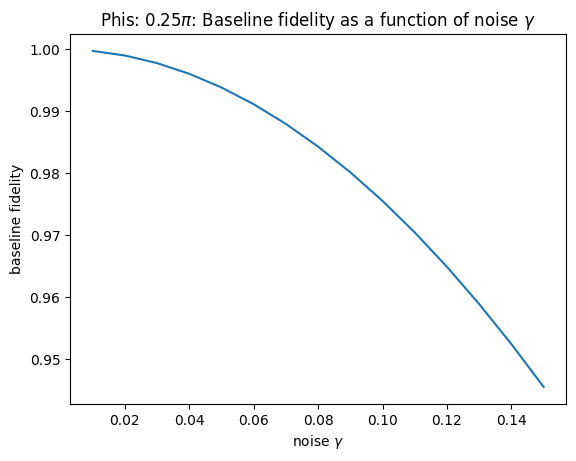

In [16]:
phi = np.pi

fids = []
for gamma in gammas:
    fids.append(fidelity_results[(phi, round(gamma, 4))])

plt.plot(gammas, fids)
plt.xlabel('noise $\gamma$')
plt.ylabel('baseline fidelity')
plt.title(f'Phis: {phis[0]/np.pi}$\\pi$: Baseline fidelity as a function of noise $\gamma$')